## Table Of Contents
<font size=3rem>
    
0 -**[ GPU SETTINGS](#GPU-SETTINGS)**<br>
1 -**[ BUSINESS UNDERSTANDING](#BUSINESS-UNDERSTANDING)**<br>
2 -**[ DATA UNDERSTANDING](#DATA-UNDERSTANDING)**<br>
3 -**[ DATA PREPARATION](#DATA-PREPARATION)**<br>
4 -**[ MODELING](#MODELING)**<br>
5 -**[ EVALUATION](#EVALUATION)<br>**
</font>
___

# BUSINESS UNDERSTANDING

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

- Determine the difference between optical illusions and reality based images.

## Import Tools

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
import cv2
import random
import datetime
from tensorflow.python.client import device_lib
from tensorflow.keras.applications.densenet import DenseNet201
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
notebook_original_start = datetime.datetime.now()

# GPU SETTINGS

In [3]:
# https://github.com/jeffheaton/present/blob/master/youtube/gpu/keras-dual-gpu.ipynb
# https://www.youtube.com/watch?v=HCLmM1PyDIs

# List of Local Devices
devices = device_lib.list_local_devices()

# Calculate size of device
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

# Data in Devices, Type, Name, Abrv, Memory
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 2070 SUPER || GPU || 5.8 GiB


In [4]:
print("Number of GPU's Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU's Available:  1


## FUNCTIONS

In [5]:
def get_num_pixels(pixel_path):
    '''
    Gets width and height of image
    :param pixel_path: String
    :return width, height: Tuple of Int
    '''
    
    width, height = Image.open(pixel_path).size
    return width, height

In [6]:
def get_image_pixels_and_paths(path):
    '''
    Joins the classes of called picture pixel count for total of called class
    :param path: String
    :return None: prints out pixel dimensions
    '''
    
    # Iterate through 5 entries to print number of pixels from image
    for path, subdirs, files in os.walk(path):
        for index, name in enumerate(files):
            image_path = os.path.join(path,name)
            print(get_num_pixels(image_path))
            if index >= 4:
                break

In [7]:
# Code Sourced from Learn.Co, modified for this project
# https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
def visualize_training_results(results):
    '''
    Renders out metric results into graphs
    :param results: tensorflow.python.keras.callbacks.History
    :return None: print out graphs
    '''
    # Assign variable for model history results
    history = results.history
    
    # Loss metric
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Accuracy metric
    plt.figure()
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['accuracy','val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Precision metric
    plt.figure()
    plt.plot(history['precision'])
    plt.plot(history['val_precision'])
    plt.legend(['precision','val_precision'])
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()
    
    # Recall metric
    plt.figure()
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    plt.legend(['recall','val_recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

 # DATA UNDERSTANDING

In [8]:
#Home Directory
home_path = r'C:\Users\c_fre\Learn.co\Module_5_Project\Illusion-Image-Classification\Images Ready for Model'

#Train Directory
train_path = os.path.join(home_path,'train')

#Validation Directory
val_path = os.path.join(home_path,'val')

#Test Directory
test_path = os.path.join(home_path,'test')

#Train Subdirectories
normal_train_path = os.path.join(train_path,'NORMAL')

autostereogram_train_path = os.path.join(train_path,'AUTOSTEREOGRAM')

#Validation Subdirectories
normal_val_path = os.path.join(val_path,'NORMAL')

autostereogram_val_path = os.path.join(val_path,'AUTOSTEREOGRAM')

#Test Subdirectories

normal_test_path = os.path.join(test_path,'NORMAL')

autostereogram_test_path = os.path.join(test_path,'AUTOSTEREOGRAM')

In [9]:
#Print to Verify Directory Pathways
print('Directory Contents:',os.listdir(home_path))
print('train Contents:',os.listdir(train_path))
print('val Contents:',os.listdir(val_path))
print('test Contents:',os.listdir(test_path))

Directory Contents: ['test', 'train', 'val']
train Contents: ['AUTOSTEREOGRAM', 'NORMAL']
val Contents: ['AUTOSTEREOGRAM', 'NORMAL']
test Contents: ['AUTOSTEREOGRAM', 'NORMAL']


In [10]:
#Cases in Training Sets
print("Number of cases in Training:",len(os.listdir(normal_train_path)) +len(os.listdir(autostereogram_train_path)))

#Autostereogram Cases in Training
print("Number of Autostereogram cases in Training:",len(os.listdir(autostereogram_train_path)))

#Normal Cases in Training
print("Number of Normal cases in Training:",len(os.listdir(normal_train_path)))

Number of cases in Training: 1370
Number of Autostereogram cases in Training: 700
Number of Normal cases in Training: 670


In [11]:
# Cases in Validation Sets
print("Number of cases in Validation:",len(os.listdir(normal_val_path)) +len(os.listdir(autostereogram_val_path)))

# Autostereogram Cases in Validation
print("Number of Autostereogram cases in Validation:",len(os.listdir(autostereogram_val_path)))

# Normal Cases in Validation
print("Number of Normal cases in Validation:",len(os.listdir(normal_val_path)))

Number of cases in Validation: 315
Number of Autostereogram cases in Validation: 150
Number of Normal cases in Validation: 165


In [12]:
#Cases in Test Sets
print("Number of cases in Test:",len(os.listdir(normal_test_path)) +len(os.listdir(autostereogram_test_path)))

#Autostereogram Cases in Test
print("Number of Autostereogram cases in Test:",len(os.listdir(autostereogram_test_path)))

#Normal cases in Test
print("Number of Normal cases in Test:",len(os.listdir(normal_test_path)))

Number of cases in Test: 315
Number of Autostereogram cases in Test: 150
Number of Normal cases in Test: 165


In [13]:
# #Total number of Normal Cases
print("Total number of Normal cases:",
      len(os.listdir(normal_test_path))+
      len(os.listdir(normal_train_path))+
      len(os.listdir(normal_val_path)))

#Total number of Autostereogram Cases
print("Total number of Autostereogram cases:",
      len(os.listdir(autostereogram_test_path))+
      len(os.listdir(autostereogram_train_path))+
      len(os.listdir(autostereogram_val_path)))

Total number of Normal cases: 1000
Total number of Autostereogram cases: 1000


In [14]:
# Validation Pixel Size
get_image_pixels_and_paths(val_path)

(671, 537)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(400, 400)
(225, 225)
(213, 237)
(208, 242)
(176, 286)


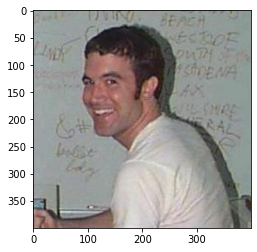

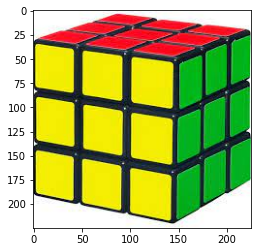

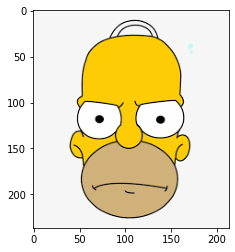

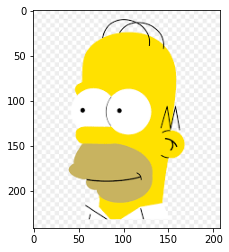

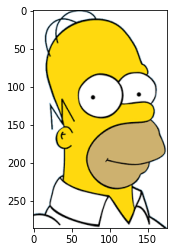

In [15]:
# Display all images in Normal Validatoin pathway
normal_val_images_display = os.listdir(normal_val_path)[:5]
for image_name in normal_val_images_display:
    image_path = os.path.join(normal_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

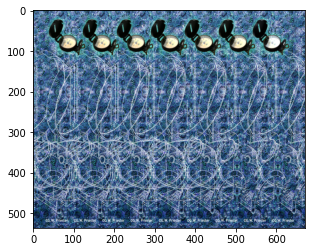

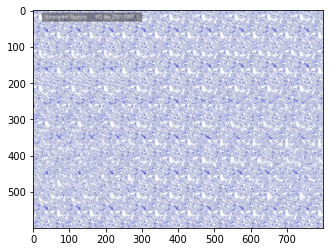

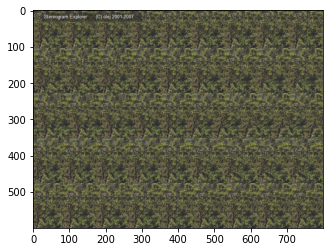

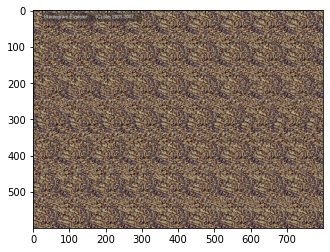

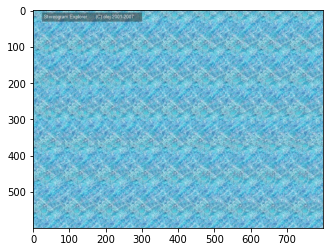

In [16]:
# Display all images in Autostereogram validation pathway
autostereogram_val_image_display = os.listdir(autostereogram_val_path)[:5]
for image_name in autostereogram_val_image_display:
    image_path = os.path.join(autostereogram_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

# DATA PREPARATION

In [17]:
# default batch size
batch_size = 32

# Set all image sizes universally
img_width, img_height = 256,256

In [18]:
# Augmentation of Training data, rescale
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=45,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest")


# Rescale validation data
val_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Rescale test data
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [19]:
# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=8675309
)

# Validation Generator
valid_generator = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=8675309
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=8675309
)

Found 1370 images belonging to 2 classes.
Found 315 images belonging to 2 classes.
Found 315 images belonging to 2 classes.


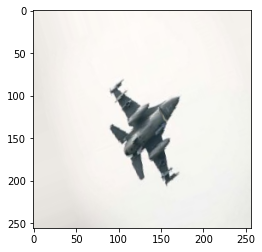

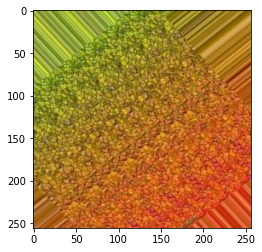

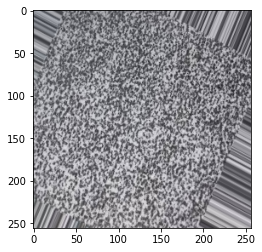

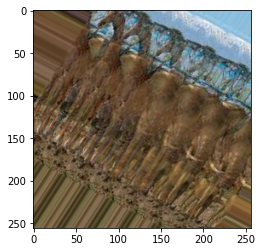

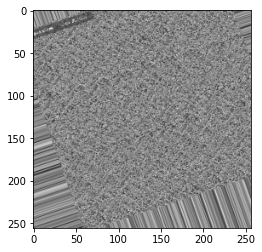

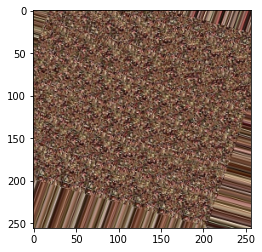

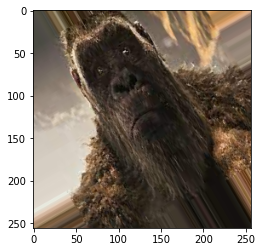

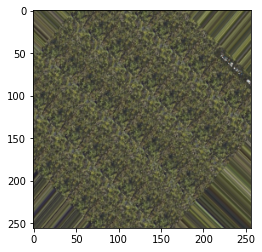

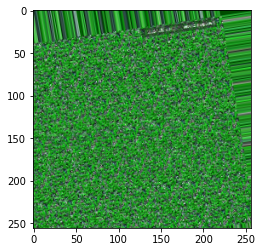

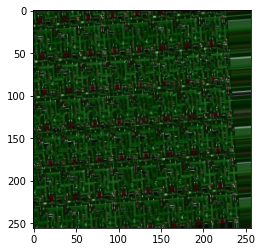

In [20]:
x,y = train_generator.next()
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    plt.show()

# MODELING

## Multi Layer Perceptron

In [21]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [22]:
# Sequential: as we want to build layers upon each other
mlp_model = keras.Sequential()

In [23]:
# Fuse paths without losing scalability
mlp_model.add(keras.layers.Flatten())

In [24]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [25]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [26]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [27]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [28]:
# Full input, Binary output with sigmoid
mlp_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [29]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
mlp_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [30]:
# Fit Model, 10 Epochs
mlp_history = mlp_model.fit(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                            validation_steps = valid_generator.n//valid_generator.batch_size,
                            epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
12/42 [=======>......................] - ETA: 14s - loss: 6.9207 - accuracy: 0.5344 - precision: 0.5185 - recall: 0.5355

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 22s 516ms/step - loss: 6.3629 - accuracy: 0.5060 - precision: 0.4959 - recall: 0.5588 - val_loss: 9.6129 - val_accuracy: 0.4653 - val_precision: 1.0000 - val_recall: 0.0065
Epoch 2/10
42/42 [==============================] - 21s 510ms/step - loss: 3.4853 - accuracy: 0.5725 - precision: 0.5599 - recall: 0.6043 - val_loss: 1.3558 - val_accuracy: 0.6458 - val_precision: 0.6095 - val_recall: 0.8649
Epoch 3/10
42/42 [==============================] - 21s 509ms/step - loss: 1.1890 - accuracy: 0.6577 - precision: 0.6390 - recall: 0.6840 - val_loss: 0.6934 - val_accuracy: 0.7847 - val_precision: 0.9027 - val_recall: 0.6667
Epoch 4/10
42/42 [==============================] - 21s 509ms/step - loss: 1.1756 - accuracy: 0.6674 - precision: 0.6501 - recall: 0.6966 - val_loss: 0.5090 - val_accuracy: 0.8507 - val_precision: 0.9077 - val_recall: 0.7919
Epoch 5/10
42/42 [==============================] - 21s 508ms/step - loss: 0.9951 - accuracy: 0.7123 - precisio

In [31]:
# Save Model Locally
mlp_model.save("MLP_Initial_Model")

INFO:tensorflow:Assets written to: MLP_Initial_Model\assets


In [32]:
# Summary of Model
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                12582976  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 12,585,729
Trainable params: 12,585,729
Non-trainable params: 0
____________________________________________

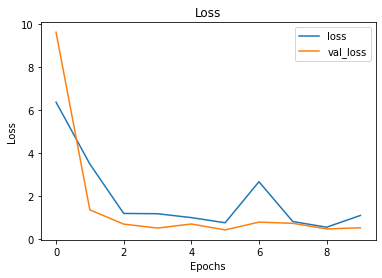

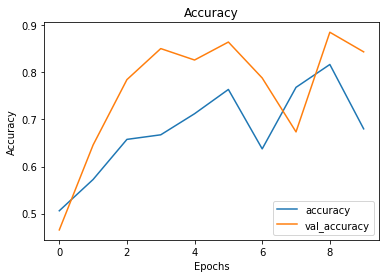

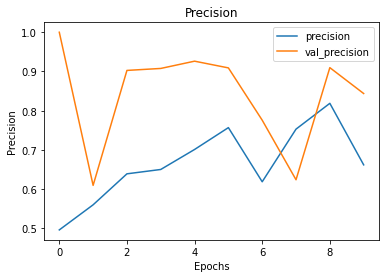

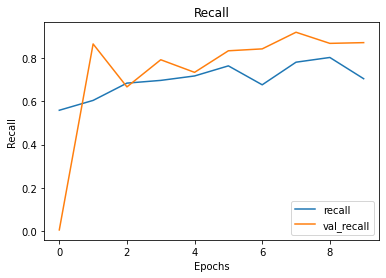

In [33]:
# Visualize Model Metrics
visualize_training_results(mlp_history)

In [34]:
# Evaluate against Training set
mlp_results_train = mlp_model.evaluate(train_generator)

 2/43 [>.............................] - ETA: 20s - loss: 0.5113 - accuracy: 0.8750 - precision: 0.8800 - recall: 0.8148

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


43/43 [==============================] - 20s 456ms/step - loss: 0.5128 - accuracy: 0.8599 - precision: 0.8424 - recall: 0.8776


In [35]:
# Evaluate against Test set
mlp_results_test = mlp_model.evaluate(test_generator)

10/10 [==============================] - 2s 245ms/step - loss: 0.9207 - accuracy: 0.7333 - precision: 0.6884 - recall: 0.8970


## CNN Model

In [36]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [37]:
# Sequential: as we want to build layers upon each other
cnn_model = keras.Sequential()

In [38]:
# 2D Convolution Layer over Images, Generate 64 filters and multiply across the image
# Filter Images to highlight features
cnn_model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3),
                                  activation='relu',
                                  input_shape=(img_width, img_height, 3)))

In [39]:
# Group images into 2x2, votes on largest, features maintained
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

In [40]:
# Fuse paths without losing scalability
cnn_model.add(keras.layers.Flatten())

In [41]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [42]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [43]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [44]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [45]:
# Full input, Binary output with sigmoid
cnn_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [46]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
cnn_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [47]:
# Summary of Model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1032256)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                66064448  
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [48]:
# Fit Model, 10 Epochs
cnn_history = cnn_model.fit(train_generator,
                        validation_data = valid_generator,
                        steps_per_epoch = train_generator.n//train_generator.batch_size,
                        validation_steps = valid_generator.n//valid_generator.batch_size,
                        epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
42/42 [==============================] - 23s 506ms/step - loss: 1.7005 - accuracy: 0.7130 - precision: 0.6983 - recall: 0.7302 - val_loss: 0.2564 - val_accuracy: 0.8958 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 2/10
42/42 [==============================] - 21s 507ms/step - loss: 0.2773 - accuracy: 0.8871 - precision: 0.8926 - recall: 0.8719 - val_loss: 0.1507 - val_accuracy: 0.9479 - val_precision: 0.9474 - val_recall: 0.9536
Epoch 3/10
42/42 [==============================] - 21s 508ms/step - loss: 0.2527 - accuracy: 0.8909 - precision: 0.8932 - recall: 0.8823 - val_loss: 0.2853 - val_accuracy: 0.9132 - val_precision: 0.9774 - val_recall: 0.8553
Epoch 4/10
42/42 [==============================] - 21s 507ms/step - loss: 0.1812 - accuracy: 0.9297 - precision: 0.9254 - recall: 0.9311 - val_loss: 0.1463 - val_accuracy: 0.9514 - val_precision: 0.9718 - val_recall: 0.9324
Epoch 5/10
42/42 [==============================] - 21s 511ms/step - loss: 0.2152 - accuracy: 0.9178

In [49]:
# Save model locally
cnn_model.save("CNN_Initial_Model")

INFO:tensorflow:Assets written to: CNN_Initial_Model\assets


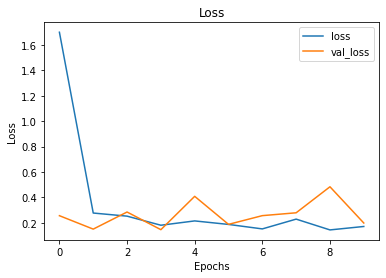

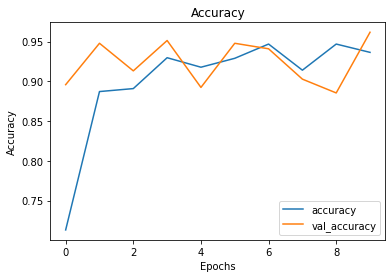

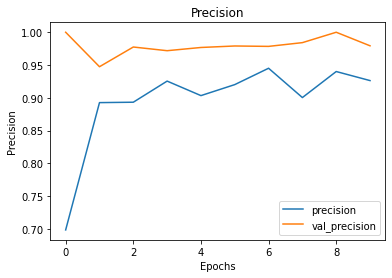

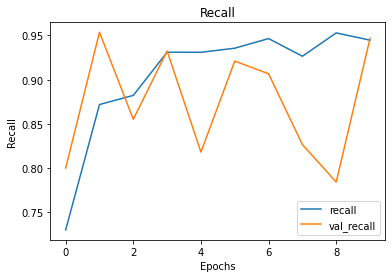

In [50]:
# Visualize Model Metrics
visualize_training_results(cnn_history)

In [51]:
# Evaluate against Training set
cnn_results_train = cnn_model.evaluate(train_generator)
cnn_results_train

27/43 [=================>............] - ETA: 7s - loss: 0.1139 - accuracy: 0.9630 - precision: 0.9476 - recall: 0.9788

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


43/43 [==============================] - 20s 457ms/step - loss: 0.1020 - accuracy: 0.9693 - precision: 0.9577 - recall: 0.9806


[0.10204082727432251,
 0.9693430662155151,
 0.9577259421348572,
 0.9805970191955566]

In [52]:
# Evaluate against Test set
cnn_results_test = cnn_model.evaluate(test_generator)
cnn_results_test

10/10 [==============================] - 3s 252ms/step - loss: 0.2119 - accuracy: 0.9460 - precision: 0.9512 - recall: 0.9455


[0.2118876576423645,
 0.9460317492485046,
 0.9512194991111755,
 0.9454545378684998]

## Finetune Models

### MLP Finetune

In [53]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [58]:
# Checkpoint, Monitor Loss, Save best results
mlp_checkpoint = tf.keras.callbacks.ModelCheckpoint("MLP_Finetune_Checkpoint",
                                                monitor="val_loss",
                                                save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
mlp_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  restore_best_weights=True)

# Reduce Learning Rate when metric has stopped improving
mlp_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10)

In [59]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
mlp_finetune_history = mlp_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[mlp_checkpoint, mlp_early_stopping, mlp_lr]
)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
26/42 [=================>............] - ETA: 7s - loss: 0.5531 - accuracy: 0.8220 - precision: 0.8170 - recall: 0.8150

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 506ms/step - loss: 0.5319 - accuracy: 0.8221 - precision: 0.8149 - recall: 0.8224 - val_loss: 0.3964 - val_accuracy: 0.8715 - val_precision: 0.9044 - val_recall: 0.8367
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 2/100
 3/42 [=>............................] - ETA: 17s - loss: 0.2803 - accuracy: 0.8958 - precision: 0.8667 - recall: 0.9070

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 513ms/step - loss: 0.5117 - accuracy: 0.8386 - precision: 0.8290 - recall: 0.8418 - val_loss: 0.5643 - val_accuracy: 0.8194 - val_precision: 0.9304 - val_recall: 0.7086
Epoch 3/100
42/42 [==============================] - 22s 514ms/step - loss: 0.9935 - accuracy: 0.7152 - precision: 0.6997 - recall: 0.7266 - val_loss: 0.5591 - val_accuracy: 0.7396 - val_precision: 0.6973 - val_recall: 0.8716
Epoch 4/100
42/42 [==============================] - 21s 506ms/step - loss: 0.5550 - accuracy: 0.8057 - precision: 0.7967 - recall: 0.8113 - val_loss: 0.4348 - val_accuracy: 0.8819 - val_precision: 0.9034 - val_recall: 0.8675
Epoch 5/100
42/42 [==============================] - 21s 511ms/step - loss: 0.7424 - accuracy: 0.7586 - precision: 0.7424 - recall: 0.7796 - val_loss: 0.4461 - val_accuracy: 0.8854 - val_precision: 0.9000 - val_recall: 0.8824
Epoch 6/100
42/42 [==============================] - 22s 515ms/step - loss: 0.7124 - accuracy: 0.7661 - prec

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 22s 514ms/step - loss: 0.5968 - accuracy: 0.7975 - precision: 0.7836 - recall: 0.8065 - val_loss: 0.4072 - val_accuracy: 0.8854 - val_precision: 0.9161 - val_recall: 0.8618
Epoch 12/100
42/42 [==============================] - 21s 513ms/step - loss: 0.3907 - accuracy: 0.8505 - precision: 0.8462 - recall: 0.8462 - val_loss: 0.3767 - val_accuracy: 0.8958 - val_precision: 0.9079 - val_recall: 0.8961
Epoch 13/100
42/42 [==============================] - 22s 515ms/step - loss: 0.3321 - accuracy: 0.8610 - precision: 0.8631 - recall: 0.8526 - val_loss: 0.3581 - val_accuracy: 0.8646 - val_precision: 0.8246 - val_recall: 0.9400
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 14/100
29/42 [===================>..........] - ETA: 6s - loss: 0.4012 - accuracy: 0.8244 - precision: 0.8137 - recall: 0.8333

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 510ms/step - loss: 0.4017 - accuracy: 0.8259 - precision: 0.8235 - recall: 0.8235 - val_loss: 0.5546 - val_accuracy: 0.7535 - val_precision: 0.7074 - val_recall: 0.8926
Epoch 15/100
42/42 [==============================] - 21s 512ms/step - loss: 0.3656 - accuracy: 0.8670 - precision: 0.8760 - recall: 0.8464 - val_loss: 0.3710 - val_accuracy: 0.8681 - val_precision: 0.8571 - val_recall: 0.9020
Epoch 16/100
42/42 [==============================] - 21s 507ms/step - loss: 0.3478 - accuracy: 0.8625 - precision: 0.8685 - recall: 0.8473 - val_loss: 0.4776 - val_accuracy: 0.8472 - val_precision: 0.9569 - val_recall: 0.7400
Epoch 17/100
42/42 [==============================] - 21s 505ms/step - loss: 0.4622 - accuracy: 0.8087 - precision: 0.7970 - recall: 0.8165 - val_loss: 0.8439 - val_accuracy: 0.6667 - val_precision: 0.6176 - val_recall: 0.9671
Epoch 18/100
42/42 [==============================] - 21s 506ms/step - loss: 0.7434 - accuracy: 0.7287 - 

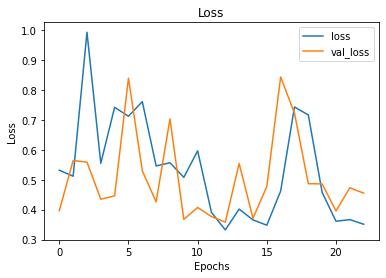

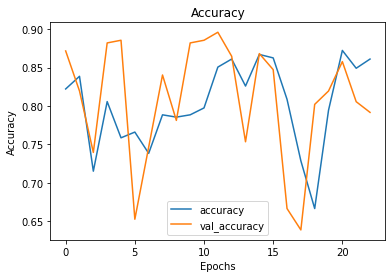

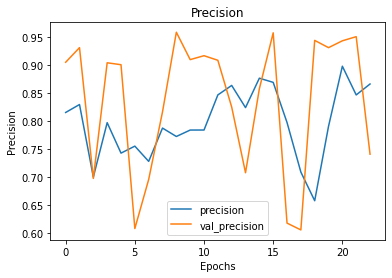

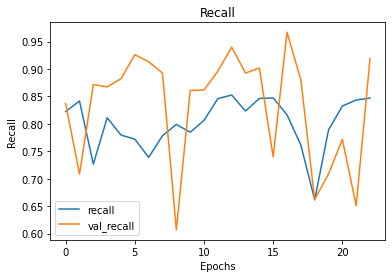

In [60]:
# Visualize Model Metrics
visualize_training_results(mlp_finetune_history)

In [61]:
# Evaluate model against Training set
mlp_results_train = mlp_model.evaluate(train_generator)

43/43 [==============================] - 20s 458ms/step - loss: 0.3359 - accuracy: 0.8555 - precision: 0.8251 - recall: 0.8940


In [62]:
# Evaluate model again Test set
mlp_results_test = mlp_model.evaluate(test_generator)

10/10 [==============================] - 2s 242ms/step - loss: 0.4815 - accuracy: 0.7968 - precision: 0.7488 - recall: 0.9212


### CNN Finetune

In [63]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [64]:
# Checkpoint, Monitor Loss, Save best results
cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint("CNN_Finetune_Checkpoint",
                                                monitor="val_loss",
                                                save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  restore_best_weights=True)
# Reduce Learning Rate when metric has stopped improving
cnn_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10)

In [65]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
cnn_finetune_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[cnn_checkpoint, cnn_early_stopping,cnn_lr]
)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
42/42 [==============================] - 22s 516ms/step - loss: 0.1219 - accuracy: 0.9567 - precision: 0.9479 - recall: 0.9652 - val_loss: 0.1786 - val_accuracy: 0.9653 - val_precision: 0.9793 - val_recall: 0.9530
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 2/100
 4/42 [=>............................] - ETA: 15s - loss: 0.1070 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.9184

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 507ms/step - loss: 0.0956 - accuracy: 0.9671 - precision: 0.9650 - recall: 0.9679 - val_loss: 0.2481 - val_accuracy: 0.9653 - val_precision: 0.9797 - val_recall: 0.9539
Epoch 3/100
42/42 [==============================] - 21s 507ms/step - loss: 0.1186 - accuracy: 0.9559 - precision: 0.9539 - recall: 0.9554 - val_loss: 0.1516 - val_accuracy: 0.9653 - val_precision: 0.9859 - val_recall: 0.9459
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 4/100
19/42 [============>.................] - ETA: 10s - loss: 0.1116 - accuracy: 0.9556 - precision: 0.9578 - recall: 0.9547

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 501ms/step - loss: 0.1122 - accuracy: 0.9574 - precision: 0.9558 - recall: 0.9573 - val_loss: 0.2632 - val_accuracy: 0.9549 - val_precision: 0.9793 - val_recall: 0.9342
Epoch 5/100
42/42 [==============================] - 21s 498ms/step - loss: 0.1318 - accuracy: 0.9529 - precision: 0.9481 - recall: 0.9554 - val_loss: 0.1758 - val_accuracy: 0.9653 - val_precision: 0.9800 - val_recall: 0.9545
Epoch 6/100
42/42 [==============================] - 21s 500ms/step - loss: 0.1578 - accuracy: 0.9432 - precision: 0.9304 - recall: 0.9559 - val_loss: 0.2598 - val_accuracy: 0.9514 - val_precision: 0.9926 - val_recall: 0.9122
Epoch 7/100
42/42 [==============================] - 21s 499ms/step - loss: 0.0957 - accuracy: 0.9686 - precision: 0.9607 - recall: 0.9754 - val_loss: 0.2864 - val_accuracy: 0.9444 - val_precision: 0.9787 - val_recall: 0.9139
Epoch 8/100
42/42 [==============================] - 21s 498ms/step - loss: 0.1395 - accuracy: 0.9462 - prec

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 22s 527ms/step - loss: 0.1222 - accuracy: 0.9634 - precision: 0.9579 - recall: 0.9681 - val_loss: 0.2337 - val_accuracy: 0.9583 - val_precision: 0.9793 - val_recall: 0.9404
Epoch 12/100
42/42 [==============================] - 22s 524ms/step - loss: 0.1216 - accuracy: 0.9596 - precision: 0.9599 - recall: 0.9570 - val_loss: 0.1566 - val_accuracy: 0.9653 - val_precision: 0.9795 - val_recall: 0.9533
Epoch 13/100
42/42 [==============================] - 22s 528ms/step - loss: 0.1130 - accuracy: 0.9589 - precision: 0.9504 - recall: 0.9664 - val_loss: 0.1386 - val_accuracy: 0.9722 - val_precision: 0.9797 - val_recall: 0.9667
Epoch 14/100
42/42 [==============================] - 22s 519ms/step - loss: 0.0933 - accuracy: 0.9671 - precision: 0.9637 - recall: 0.9696 - val_loss: 0.1086 - val_accuracy: 0.9792 - val_precision: 0.9799 - val_recall: 0.9799
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 15/100
25/42 [================>..

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 501ms/step - loss: 0.1103 - accuracy: 0.9656 - precision: 0.9645 - recall: 0.9645 - val_loss: 0.2408 - val_accuracy: 0.9444 - val_precision: 0.9784 - val_recall: 0.9128
Epoch 16/100
42/42 [==============================] - 21s 502ms/step - loss: 0.0933 - accuracy: 0.9679 - precision: 0.9721 - recall: 0.9617 - val_loss: 0.1471 - val_accuracy: 0.9722 - val_precision: 0.9800 - val_recall: 0.9671
Epoch 17/100
42/42 [==============================] - 21s 501ms/step - loss: 0.0953 - accuracy: 0.9701 - precision: 0.9677 - recall: 0.9707 - val_loss: 0.1529 - val_accuracy: 0.9618 - val_precision: 0.9787 - val_recall: 0.9452
Epoch 18/100
42/42 [==============================] - 21s 501ms/step - loss: 0.0934 - accuracy: 0.9709 - precision: 0.9708 - recall: 0.9693 - val_loss: 0.1657 - val_accuracy: 0.9688 - val_precision: 0.9796 - val_recall: 0.9600
Epoch 19/100
42/42 [==============================] - 21s 505ms/step - loss: 0.1241 - accuracy: 0.9596 - 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 500ms/step - loss: 0.1035 - accuracy: 0.9671 - precision: 0.9625 - recall: 0.9712 - val_loss: 0.1308 - val_accuracy: 0.9722 - val_precision: 0.9792 - val_recall: 0.9658
Epoch 25/100
42/42 [==============================] - 21s 504ms/step - loss: 0.1200 - accuracy: 0.9604 - precision: 0.9599 - recall: 0.9585 - val_loss: 0.1460 - val_accuracy: 0.9653 - val_precision: 0.9929 - val_recall: 0.9392
Epoch 26/100
42/42 [==============================] - 21s 497ms/step - loss: 0.0808 - accuracy: 0.9746 - precision: 0.9740 - recall: 0.9740 - val_loss: 0.1361 - val_accuracy: 0.9722 - val_precision: 0.9790 - val_recall: 0.9655
Epoch 27/100
42/42 [==============================] - 21s 499ms/step - loss: 0.0738 - accuracy: 0.9746 - precision: 0.9695 - recall: 0.9785 - val_loss: 0.1471 - val_accuracy: 0.9722 - val_precision: 0.9797 - val_recall: 0.9667
Epoch 28/100
42/42 [==============================] - 21s 502ms/step - loss: 0.1009 - accuracy: 0.9596 - 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 500ms/step - loss: 0.1076 - accuracy: 0.9649 - precision: 0.9607 - recall: 0.9680 - val_loss: 0.0812 - val_accuracy: 0.9792 - val_precision: 0.9801 - val_recall: 0.9801
Epoch 31/100
42/42 [==============================] - 21s 499ms/step - loss: 0.0949 - accuracy: 0.9679 - precision: 0.9607 - recall: 0.9739 - val_loss: 0.0899 - val_accuracy: 0.9688 - val_precision: 0.9797 - val_recall: 0.9603
Epoch 32/100
42/42 [==============================] - 21s 500ms/step - loss: 0.1061 - accuracy: 0.9611 - precision: 0.9548 - recall: 0.9665 - val_loss: 0.0573 - val_accuracy: 0.9826 - val_precision: 0.9865 - val_recall: 0.9799
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 33/100
17/42 [===========>..................] - ETA: 11s - loss: 0.1095 - accuracy: 0.9591 - precision: 0.9487 - recall: 0.9700

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 21s 494ms/step - loss: 0.1203 - accuracy: 0.9567 - precision: 0.9517 - recall: 0.9604 - val_loss: 0.0898 - val_accuracy: 0.9757 - val_precision: 0.9795 - val_recall: 0.9728
Epoch 34/100
42/42 [==============================] - 21s 498ms/step - loss: 0.0977 - accuracy: 0.9694 - precision: 0.9609 - recall: 0.9771 - val_loss: 0.1397 - val_accuracy: 0.9688 - val_precision: 0.9931 - val_recall: 0.9470
Epoch 35/100
42/42 [==============================] - 21s 491ms/step - loss: 0.0812 - accuracy: 0.9725 - precision: 0.9683 - recall: 0.9756 - val_loss: 0.0992 - val_accuracy: 0.9722 - val_precision: 0.9801 - val_recall: 0.9673
Epoch 36/100
42/42 [==============================] - 21s 496ms/step - loss: 0.0635 - accuracy: 0.9806 - precision: 0.9758 - recall: 0.9847 - val_loss: 0.1076 - val_accuracy: 0.9722 - val_precision: 0.9796 - val_recall: 0.9664
Epoch 37/100
42/42 [==============================] - 21s 495ms/step - loss: 0.0912 - accuracy: 0.9664 - 

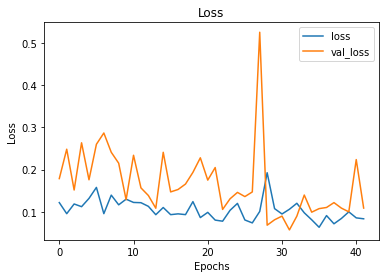

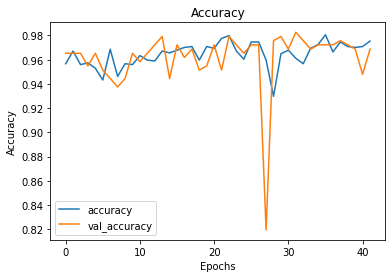

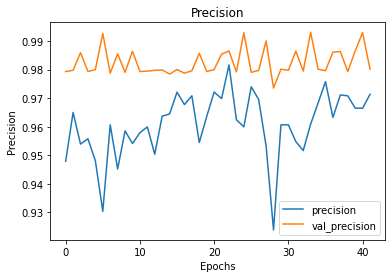

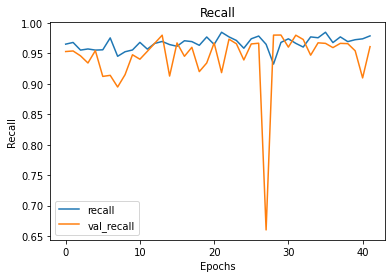

In [66]:
# Visualize Model Metrics
visualize_training_results(cnn_finetune_history)

In [67]:
# Evaluate against Training set
cnn_results_train = cnn_model.evaluate(train_generator)

43/43 [==============================] - 19s 450ms/step - loss: 0.1035 - accuracy: 0.9664 - precision: 0.9407 - recall: 0.9940


In [68]:
# Evaluate against Test set
cnn_results_test = cnn_model.evaluate(test_generator)

10/10 [==============================] - 2s 236ms/step - loss: 0.1578 - accuracy: 0.9524 - precision: 0.9412 - recall: 0.9697


## Pretrained Model

In [69]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [70]:
# Initialize Pretrain Base Model
pretrain_base = DenseNet201(weights=None,
                 include_top=False,
                 input_shape=(img_width, img_height, 3))

# Define Model Architecture
pretrain_model = keras.Sequential()
pretrain_model.add(pretrain_base)
pretrain_model.add(keras.layers.Flatten())
pretrain_model.add(keras.layers.Dense(64, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(256, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Do NOT train the base
pretrain_base.trainable = False

# Summary of Model
pretrain_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                7864384   
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [71]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
pretrain_model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')])

In [72]:
# Fit Model, 10 Epochs
pretrain_model_history = pretrain_model.fit(train_generator,
                                            validation_data = valid_generator,
                                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                                            validation_steps = valid_generator.n//valid_generator.batch_size,
                                            epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
42/42 [==============================] - 32s 587ms/step - loss: 0.5563 - accuracy: 0.7010 - precision: 0.6698 - recall: 0.7585 - val_loss: 0.2137 - val_accuracy: 0.9340 - val_precision: 0.9645 - val_recall: 0.9067
Epoch 2/10
42/42 [==============================] - 21s 504ms/step - loss: 0.2393 - accuracy: 0.8976 - precision: 0.8846 - recall: 0.9102 - val_loss: 0.1235 - val_accuracy: 0.9479 - val_precision: 0.9853 - val_recall: 0.9116
Epoch 3/10
42/42 [==============================] - 21s 499ms/step - loss: 0.1829 - accuracy: 0.9283 - precision: 0.9198 - recall: 0.9339 - val_loss: 0.0759 - val_accuracy: 0.9757 - val_precision: 0.9805 - val_recall: 0.9742
Epoch 4/10
42/42 [==============================] - 21s 502ms/step - loss: 0.1187 - accuracy: 0.9589 - precision: 0.9545 - recall: 0.9618 - val_loss: 0.1137 - val_accuracy: 0.9583 - val_precision: 0.9929 - val_recall: 0.9267
Epoch 5/10
42/42 [==============================] - 21s 501ms/step - loss: 0.1243 - accuracy: 0.9529

In [73]:
# Save model locally
pretrain_model.save("Pretrain_Initial_Model")

INFO:tensorflow:Assets written to: Pretrain_Initial_Model\assets


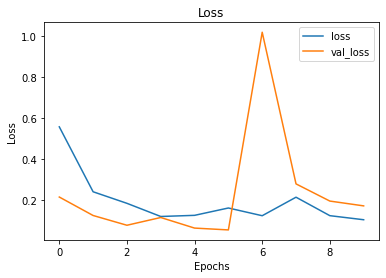

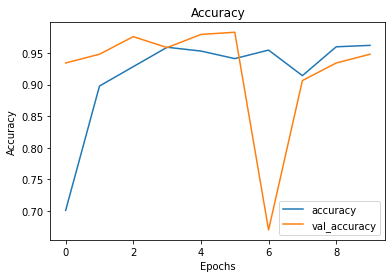

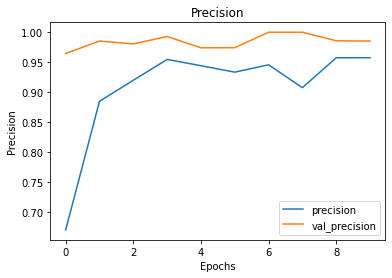

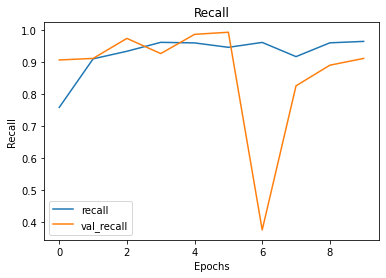

In [74]:
# Visualize Model Metrics
visualize_training_results(pretrain_model_history)

In [75]:
# Evaluate model against Training set
pretrain_results_train = pretrain_model.evaluate(train_generator)
pretrain_results_train

24/43 [===============>..............] - ETA: 8s - loss: 0.1244 - accuracy: 0.9544 - precision: 0.9941 - recall: 0.9113

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


43/43 [==============================] - 20s 468ms/step - loss: 0.1269 - accuracy: 0.9526 - precision: 0.9935 - recall: 0.9090


[0.12685702741146088,
 0.9525547623634338,
 0.9934747219085693,
 0.9089552164077759]

In [76]:
# Evaluate model against Test set
pretrain_results_test = pretrain_model.evaluate(test_generator)
pretrain_results_test

10/10 [==============================] - 5s 467ms/step - loss: 0.1611 - accuracy: 0.9556 - precision: 0.9809 - recall: 0.9333


[0.16108447313308716,
 0.9555555582046509,
 0.9808917045593262,
 0.9333333373069763]

## Finetune Pretrain

In [77]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [78]:
# Checkpoint, Monitor Loss, Save best results
pretrain_model_checkpoint = tf.keras.callbacks.ModelCheckpoint("Finetune_Pretrain_Checkpoint",
                                                               monitor="val_loss",
                                                               save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
pretrain_model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                                 monitor="val_loss",
                                                                 restore_best_weights=True)
# Reduce Learning Rate when metric has stopped improving
pretrain_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10)

In [79]:
# Initialize Pretrain Base Model
finetune_pretrain_base = DenseNet201(weights=None,
                                     include_top=False,
                                     input_shape=(img_width, img_height, 3))

# Define Model Architecture
finetune_pretrain_base = keras.Sequential()
finetune_pretrain_base.add(pretrain_base)
finetune_pretrain_base.add(keras.layers.Flatten())
finetune_pretrain_base.add(keras.layers.Dense(64, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(256, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(1, activation='sigmoid'))

# Do NOT train the base
finetune_pretrain_base.trainable = False

# Summary of Model
finetune_pretrain_base.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                7864384   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [80]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
finetune_pretrain_base.compile(loss="binary_crossentropy",
                               optimizer="adam",
                               metrics=['accuracy',
                                        tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall')])

In [81]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
finetune_pretrain_model_history = pretrain_model.fit(train_generator,
                                                     validation_data = valid_generator,
                                                     steps_per_epoch = train_generator.n//train_generator.batch_size,
                                                     validation_steps = valid_generator.n//valid_generator.batch_size,
                                                     callbacks=[pretrain_model_checkpoint, pretrain_model_early_stopping, 
                                                                pretrain_lr],
                                                     epochs=100)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
42/42 [==============================] - 22s 524ms/step - loss: 0.1099 - accuracy: 0.9589 - precision: 0.9572 - recall: 0.9587 - val_loss: 0.1003 - val_accuracy: 0.9688 - val_precision: 0.9494 - val_recall: 0.9934
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 2/100
27/42 [==================>...........] - ETA: 7s - loss: 0.0910 - accuracy: 0.9662 - precision: 0.9646 - recall: 0.9669

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 22s 528ms/step - loss: 0.1007 - accuracy: 0.9649 - precision: 0.9593 - recall: 0.9696 - val_loss: 0.0514 - val_accuracy: 0.9861 - val_precision: 0.9868 - val_recall: 0.9868
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 3/100
40/42 [===========================>..] - ETA: 1s - loss: 0.0800 - accuracy: 0.9717 - precision: 0.9695 - recall: 0.9726

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 24s 565ms/step - loss: 0.0806 - accuracy: 0.9709 - precision: 0.9680 - recall: 0.9725 - val_loss: 0.0507 - val_accuracy: 0.9826 - val_precision: 0.9870 - val_recall: 0.9806
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 4/100
 1/42 [..............................] - ETA: 25s - loss: 0.0940 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 24s 571ms/step - loss: 0.1150 - accuracy: 0.9544 - precision: 0.9502 - recall: 0.9574 - val_loss: 0.0937 - val_accuracy: 0.9722 - val_precision: 0.9554 - val_recall: 0.9934
Epoch 5/100
42/42 [==============================] - 24s 569ms/step - loss: 0.0976 - accuracy: 0.9664 - precision: 0.9565 - recall: 0.9755 - val_loss: 0.0925 - val_accuracy: 0.9688 - val_precision: 0.9929 - val_recall: 0.9459
Epoch 6/100
42/42 [==============================] - 24s 569ms/step - loss: 0.0824 - accuracy: 0.9701 - precision: 0.9679 - recall: 0.9709 - val_loss: 0.1348 - val_accuracy: 0.9549 - val_precision: 0.9857 - val_recall: 0.9262
Epoch 7/100
42/42 [==============================] - 24s 568ms/step - loss: 0.0802 - accuracy: 0.9761 - precision: 0.9727 - recall: 0.9786 - val_loss: 0.1050 - val_accuracy: 0.9722 - val_precision: 0.9860 - val_recall: 0.9592
Epoch 8/100
42/42 [==============================] - 24s 571ms/step - loss: 0.0974 - accuracy: 0.9634 - prec

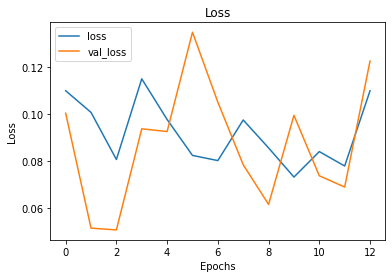

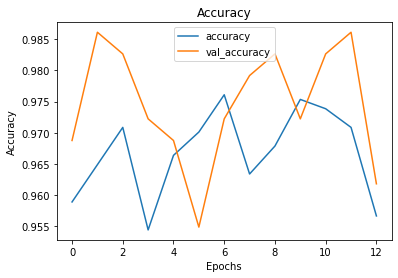

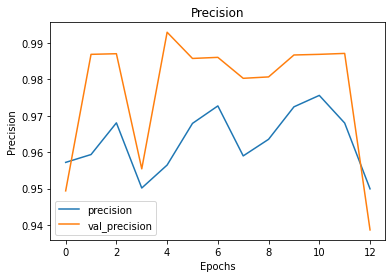

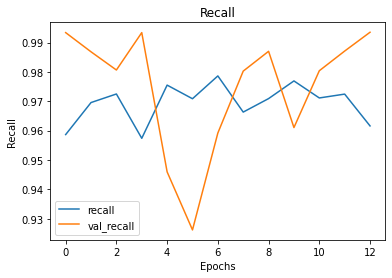

In [82]:
# Visualize Model Metrics
visualize_training_results(finetune_pretrain_model_history)

In [83]:
# Evaluate Model against Training set
finetune_pretrain_results_train = pretrain_model.evaluate(train_generator)
finetune_pretrain_results_train

43/43 [==============================] - 24s 544ms/step - loss: 0.0681 - accuracy: 0.9759 - precision: 0.9636 - recall: 0.9881


[0.06805942952632904,
 0.9759123921394348,
 0.9636098742485046,
 0.9880596995353699]

In [84]:
# Evaluate Model against Test set
finetune_pretrain_results_test = pretrain_model.evaluate(test_generator)
finetune_pretrain_results_test

10/10 [==============================] - 3s 295ms/step - loss: 0.1714 - accuracy: 0.9397 - precision: 0.9056 - recall: 0.9879


[0.1713571846485138,
 0.9396825432777405,
 0.9055555462837219,
 0.9878787994384766]

# EVALUATION

In [85]:
# Load saved model
mlp_original_model = keras.models.load_model('MLP_Initial_Model')

In [86]:
scores = mlp_original_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

10/10 [==============================] - 3s 287ms/step - loss: 0.9207 - accuracy: 0.7333 - precision: 0.6884 - recall: 0.8970
Loss of the model: 92.07%
Test Accuracy: 73.33%
Test Precision: 68.84%
Test Recall: 89.70%


In [87]:
# Load saved model
mlp_finetune_model = keras.models.load_model('MLP_Finetune_Checkpoint')

In [88]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = mlp_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

10/10 [==============================] - 3s 294ms/step - loss: 0.4815 - accuracy: 0.7968 - precision: 0.7488 - recall: 0.9212
Loss of the model: 48.15%
Test Accuracy: 79.68%
Test Precision: 74.88%
Test Recall: 92.12%


In [89]:
# Load saved model
cnn_initial_model = keras.models.load_model('CNN_Initial_Model')

In [90]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = cnn_initial_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

10/10 [==============================] - 3s 296ms/step - loss: 0.2119 - accuracy: 0.9460 - precision: 0.9512 - recall: 0.9455
Loss of the model: 21.19%
Test Accuracy: 94.60%
Test Precision: 95.12%
Test Recall: 94.55%


In [91]:
# Load saved model
cnn_finetune_model = keras.models.load_model('CNN_Finetune_Checkpoint')

In [92]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = cnn_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

10/10 [==============================] - 3s 298ms/step - loss: 0.1578 - accuracy: 0.9524 - precision: 0.9412 - recall: 0.9697
Loss of the model: 15.78%
Test Accuracy: 95.24%
Test Precision: 94.12%
Test Recall: 96.97%


In [93]:
# Load saved model
pretrain_model = keras.models.load_model('Pretrain_Initial_Model')

In [94]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = pretrain_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

10/10 [==============================] - 6s 312ms/step - loss: 0.1611 - accuracy: 0.9556 - precision: 0.9809 - recall: 0.9333
Loss of the model: 16.11%
Test Accuracy: 95.56%
Test Precision: 98.09%
Test Recall: 93.33%


In [95]:
# Load saved model
pretrain_finetune_model = keras.models.load_model('Finetune_Pretrain_Checkpoint')

In [96]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = pretrain_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

10/10 [==============================] - 6s 333ms/step - loss: 0.1714 - accuracy: 0.9397 - precision: 0.9056 - recall: 0.9879
Loss of the model: 17.14%
Test Accuracy: 93.97%
Test Precision: 90.56%
Test Recall: 98.79%


In [97]:
# Notebook Stop, Total Time.
notebook_end = datetime.datetime.now()
notebook_elapsed = notebook_end - notebook_original_start
print('Notebook took a total of {}'.format(elapsed))

Notebook took a total of 0:07:57.161183


| Metrics           | Loss   | Accuracy | Precision | Recall |
|-------------------|--------|----------|-----------|--------|
| MLP Original      | 92.07% | 73.33%   | 68.84%    | 89.70% |
| MLP Finetune      | 48.15% | 79.68%   | 74.88%    | 92.12% |
| CNN Original      | 21.19% | 94.60%   | 95.12%    | 94.55% |
| CNN Finetune      | 15.78% | 95.24%   | 94.12%    | 96.97% |
| Pretrain Original | 16.11% | 95.56%   | 98.09%    | 93.33% |
| Pretrain Finetune | 17.14% | 93.97%   | 90.56%    | 98.79% |